# Lab2. Detect License plate with SageMaker built-in algorithm

In this lab, you will build a model to recognize license plate area from images that we generated in Lab1.

In [1]:
import os 

## Divide train and valdiation data from gnenrated images

* prepare folder to store divided train/validation data

In [2]:
!rm -fR od
!mkdir od od/od-train od/od-train_annotation od/od-validation od/od-validation_annotation

In [3]:
jsons = os.listdir('gen/gen-tags')
print ('There are {:,} images have annotation files'.format(len(jsons)))

There are 5,000 images have annotation files


* Define the number of train/valdiation images

In [4]:
n_samples = len(jsons)
n_val = 5000 if n_samples > 25000 else round(n_samples * 0.2)
n_train = n_samples - n_val
print('{:,} images will be used for training, and {:,} images will be used for validation.'.format(n_train, n_val))

4,000 images will be used for training, and 1,000 images will be used for validation.


* Move images and annotation files to od-train and od-validation folders  
 **(Note that cropped-imgs and nums-tags files are not moved.)**

In [5]:
import shutil

train_jsons = jsons[:n_train]
val_jsons = jsons[n_train:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './gen/gen-imgs/'+i.split('.')[0]+'.png'
    shutil.move(image_file, './od/od-train/')
    shutil.move('./gen/gen-tags/'+i, './od/od-train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './gen/gen-imgs/'+i.split('.')[0]+'.png'
    shutil.move(image_file, './od/od-validation/')
    shutil.move('./gen/gen-tags/'+i, './od/od-validation_annotation/')

* check the move result

In [21]:
print('there are {:,} files in gen/gen-imgs folder.'.format(len(os.listdir('gen/gen-imgs'))))
print('there are {:,} files in gen/gen-tags folder.'.format(len(os.listdir('gen/gen-tags'))))
print('there are {:,} files in od/od-train folder.'.format(len(os.listdir('od/od-train'))))
print('there are {:,} files in od/od-train_annotation folder.'.format(len(os.listdir('od/od-train_annotation'))))
print('there are {:,} files in od/od-validation folder.'.format(len(os.listdir('od/od-validation'))))
print('there are {:,} files in od/od-validation_annotation folder.'.format(len(os.listdir('od/od-validation_annotation'))))

there are 0 files in gen/gen-imgs folder.
there are 0 files in gen/gen-tags folder.
there are 4,000 files in od/od-train folder.
there are 4,000 files in od/od-train_annotation folder.
there are 1,000 files in od/od-validation folder.
there are 1,000 files in od/od-validation_annotation folder.


## Upload the data to S3

* Set up SageMaker

In [7]:
from PIL import Image
import json
import matplotlib.image as mpimg

In [8]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::308961792850:role/service-role/AmazonSageMaker-ExecutionRole-20180531T094549
CPU times: user 597 ms, sys: 77.7 ms, total: 675 ms
Wall time: 913 ms


* **Make sure you change the bucket name None with your S3 bucket name**


In [13]:
bucket = None#'leonkang-datalake-nv' # custom bucket name.
prefix = 'anpr'
assert bucket != None

* Upload files to S3
* It may take several minutes **(4~5 minutes for 5,000 images)**

In [23]:
%%time

train_channel = prefix + '/od/od-train'
validation_channel = prefix + '/od/od-validation'
train_annotation_channel = prefix + '/od/od-train_annotation'
validation_annotation_channel = prefix + '/od/od-validation_annotation'

sess.upload_data(path='od/od-train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='od/od-validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='od/od-train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='od/od-validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 20.6 s, sys: 1.3 s, total: 21.9 s
Wall time: 3min 6s


* Check upload results 

In [67]:
!aws s3 ls {bucket}/anpr/od/od-train/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-train_annotation/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-validation/ |wc -l
!aws s3 ls {bucket}/anpr/od/od-validation_annotation/ |wc -l

4000
4000
1000
1000


In [43]:
s3_output_location = 's3://{}/{}/od-output'.format(bucket, prefix)

## Training with built-in algorithm
* Prepare SageMaker built-in Object Detection algorithm container

In [44]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


* Define Object Detection Estimator and Hyperparameters
* Refer to SageMaker Estimator API -> https://sagemaker.readthedocs.io/en/stable/estimators.html
* Note that we set parameters as below:
    * train_instance_type: ml.p3.16xlarge
    * **base_network: resnet-50**
    * **use_transfer_model: True**
    * epochs: 20
    * mini_batch_size: 64
    * learning_rate: 0.001
    

In [45]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.16xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         tags=[{"Key":"anpr","Value":"anpr-plate detection"}],
                                         sagemaker_session=sess)

In [46]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             mini_batch_size=64,
                             epochs=20,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='adam',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=n_train)

* Pass the channel of S3 paths as a dictionary to the Estimator
* Ref to Sessions -> https://sagemaker.readthedocs.io/en/stable/session.html#sagemaker.session.s3_input

In [47]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

* Start the training.
* **It may take 10~20 minutes.**

In [49]:
%%time
od_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2019-03-08-15-16-40-979


2019-03-08 15:16:41 Starting - Starting the training job...
2019-03-08 15:16:42 Starting - Launching requested ML instances.........
2019-03-08 15:18:19 Starting - Preparing the instances for training......
2019-03-08 15:19:13 Downloading - Downloading input data......
2019-03-08 15:20:40 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[03/08/2019 15:20:47 INFO 140277851719488] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_objective

## Inference Object Detection

* Deploy trained model to SageMaker endpoint
* You can add Elastic Inference(EI, adding GPU power) by using 'accelerator_type' parameter
* Refer to types of EI asselerator below:
    * https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ei.html

In [50]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.c5.xlarge',
                                 accelerator_type='ml.eia1.medium')

INFO:sagemaker:Creating model with name: object-detection-2019-03-08-15-33-29-692
INFO:sagemaker:Creating endpoint with name object-detection-2019-03-08-15-16-40-979


---------------------------------------------------------------!

* Check the endpoint name

In [58]:
print(object_detector.endpoint)

object-detection-2019-03-08-15-16-40-979


* Define bounding box visualization function 

In [61]:
import matplotlib.pyplot as plt
def visualize_detection(img_file, dets, code, thresh=0.6):
        import random
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = x0 * width
            ymin = y0 * height
            xmax = x1 * width
            ymax = y1 * height
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            #if classes and len(classes) > cls_id:class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(code, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')

        plt.show()

* Test licence plate detection of 10 sample image 

In [62]:
test_imgs = os.listdir('od/od-validation')
threshold = 0.4

{'prediction': [[0.0, 0.9998819828033447, 0.2366408109664917, 0.3542192578315735, 0.7429115176200867, 0.6565665602684021]]}


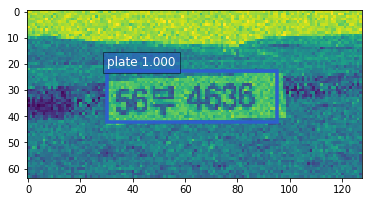

{'prediction': [[0.0, 0.9998973608016968, 0.2213364541530609, 0.28666025400161743, 0.7986845970153809, 0.7018340826034546]]}


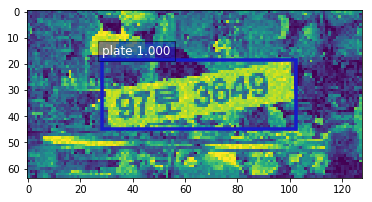

{'prediction': [[0.0, 0.9999102354049683, 0.1062823235988617, 0.300470769405365, 0.919567346572876, 0.6725448966026306]]}


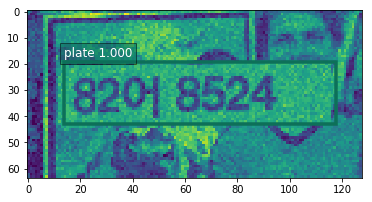

{'prediction': [[0.0, 0.9998637437820435, 0.1646222472190857, 0.28847694396972656, 0.8292056918144226, 0.6781942844390869]]}


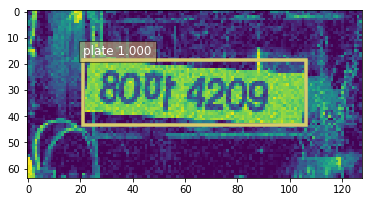

{'prediction': [[0.0, 0.9972761273384094, 0.1734483242034912, 0.24886712431907654, 0.8415244817733765, 0.7013509273529053]]}


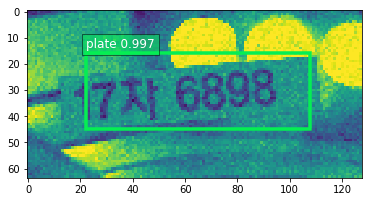

{'prediction': [[0.0, 0.9989086389541626, 0.1021609902381897, 0.30378952622413635, 0.8805958032608032, 0.6989010572433472]]}


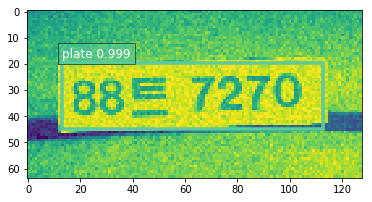

{'prediction': [[0.0, 0.9995013475418091, 0.17593318223953247, 0.32131528854370117, 0.7948530912399292, 0.618520975112915]]}


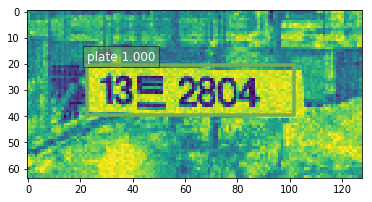

{'prediction': [[0.0, 0.9995582699775696, 0.16420120000839233, 0.32940036058425903, 0.8182984590530396, 0.6628777384757996]]}


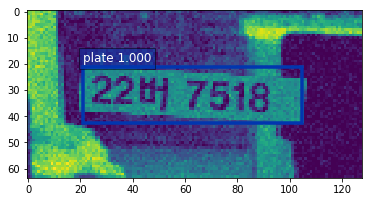

{'prediction': [[0.0, 0.9997161030769348, 0.09719902276992798, 0.21187067031860352, 0.8918550610542297, 0.7420557141304016]]}


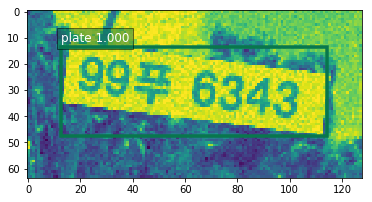

{'prediction': [[0.0, 0.9999343156814575, 0.0997132658958435, 0.27523964643478394, 0.8822569847106934, 0.7086827754974365]]}


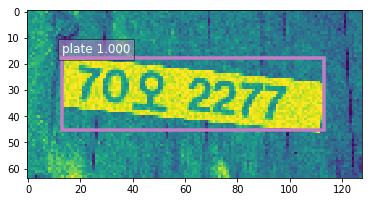

CPU times: user 2.25 s, sys: 2.02 s, total: 4.27 s
Wall time: 1.82 s


In [64]:
%%time
for i in test_imgs[:10]:
    ifile = 'od/od-validation/' + i
    with open(ifile, "rb") as image:
        f = image.read()
        b = bytearray(f)
        results = object_detector.predict(b)
        detections = json.loads(results)
        print(detections)
    visualize_detection(ifile, detections['prediction'], 'plate', threshold)